In [1]:
!pip install caer canaro

     |████████████████████████████████| 809 kB 291 kB/s            
     |████████████████████████████████| 21.5 MB 1.6 MB/s             
     |████████████████████████████████| 743 kB 59.7 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77059 sha256=216d1a391c1314c5283c82e8f06c47cb4d29e7c83803c6acf9f77efedb9abe0e
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: typed-ast
    Found existing installation: typed-ast 1.5.0
    Uninstalling typed-as

In [2]:
!pip install tensorflow-io-gcs-filesystem

     |████████████████████████████████| 2.1 MB 289 kB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.22.0 which is incompatible.


In [3]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [4]:
IMG_SIZE = (80,80)
channels = 1 #for grascale
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [5]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [6]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [7]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 1.7830417156219482s
[INFO] At 1000 files
[INFO] 1454 files found in 0.6217772960662842s
[INFO] At 1000 files
[INFO] 1452 files found in 0.5611538887023926s
[INFO] At 1000 files
[INFO] 1354 files found in 0.439833402633667s
[INFO] At 1000 files
[INFO] 1342 files found in 0.3879549503326416s
[INFO] At 1000 files
[INFO] 1291 files found in 0.2806873321533203s
[INFO] At 1000 files
[INFO] 1206 files found in 0.1260824203491211s
[INFO] At 1000 files
[INFO] 1194 files found in 0.11366605758666992s
[INFO] At 1000 files
[INFO] 1193 files found in 0.10703039169311523s
[INFO] At 1000 files
[INFO] 1079 files found in 0.004275798797607422s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 54s


In [8]:
# Number of training samples
len(train)

13811

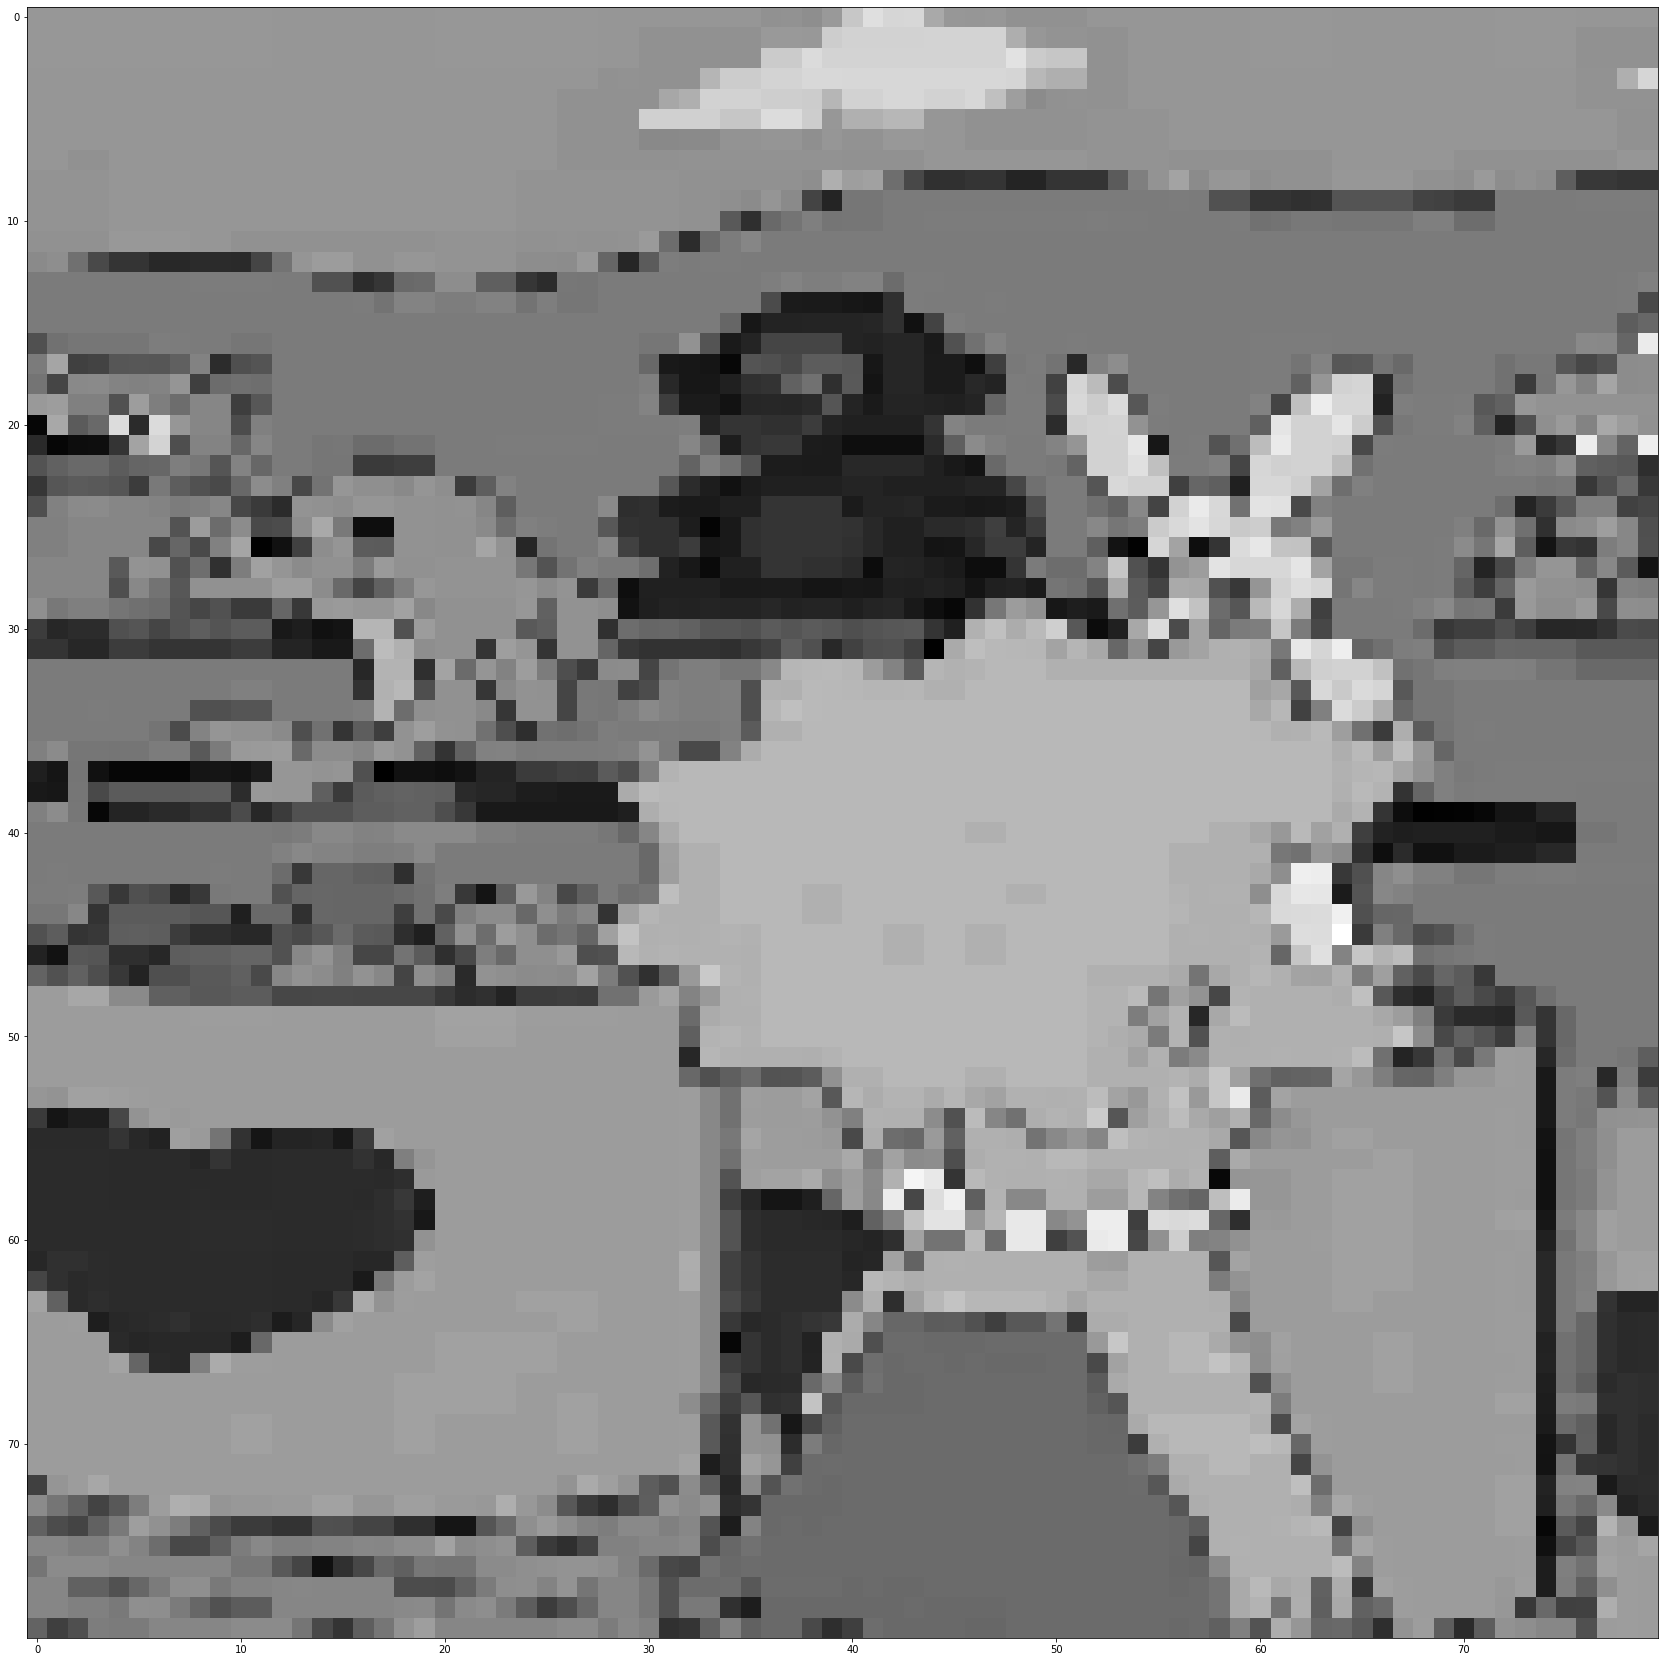

In [9]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [10]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [11]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(featureSet, labels, test_size=.2)

In [13]:
del train
del featureSet
del labels 
gc.collect()

3277

In [14]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [15]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [16]:
# Create our model (returns a compiled model)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-6, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [18]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 17s 29ms/step - loss: 0.3413 - accuracy: 0.1548 - val_loss: 0.3341 - val_accuracy: 0.1647
Epoch 2/10
345/345 [==============================] - 10s 28ms/step - loss: 0.3238 - accuracy: 0.1586
Epoch 3/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3235 - accuracy: 0.1615
Epoch 4/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3229 - accuracy: 0.1623
Epoch 5/10
345/345 [==============================] - 9s 27ms/step - loss: 0.3199 - accuracy: 0.1688
Epoch 6/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3094 - accuracy: 0.2172
Epoch 7/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3052 - accuracy: 0.2326
Epoch 8/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3018 - accuracy: 0.2538
Epoch 9/10
345/345 [==============================] - 9s 26ms/step - loss: 0.2994 - accuracy: 0.2665
Epoch 10/10
345/345 [==========================

In [19]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

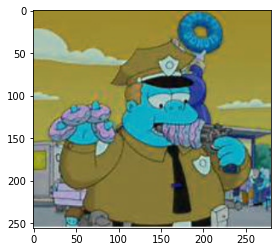

In [20]:
test_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset/chief_wiggum/pic_0008.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [21]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [22]:
predictions = model.predict(prepare(img))
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

moe_szyslak
